In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import os
import seaborn as sns
from varname import nameof

import tensorflow as tf
import tensorflow_probability as tfp

2024-07-01 09:35:00.853119: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 09:35:01.359433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# tfp particulars
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

In [3]:
# This is the CPU tf version - we have noticed this to be quicker than the GPU verison
tf.config.list_physical_devices("GPU")

[]

In [4]:
# Split the data into train and test data

def split_train_test_data(sub_image_df, path_to_df, n_forecasting):
    # join the paths
    complete_path_to_df = os.path.join(path_to_df, sub_image_df)
    # read the csv 
    read_df = pd.read_csv(complete_path_to_df)

    # split the data into train and test
    train_df = read_df.iloc[:-n_forecasting, :]
    print(train_df.shape)
    test_df = read_df.iloc[-n_forecasting:,:]
    print(test_df.shape)

    # get the obs data
    train_y = train_df['tassel_count']
    test_y = test_df['tassel_count']

    # make these float 32 for bayes ts implementation
    train_y = train_y.astype("float32")
    test_y = test_y.astype("float32")

    # these needs to be returned

    # also split the covariate data
    # but add an intercept before the split?
    read_df.insert(0, 'intercept', np.repeat(1, read_df.shape[0]))
    # make this float32 for bayes ts implementation
    read_df['intercept'] = read_df['intercept'].astype("float32")

    # now can extact the covariate data
    X_preds = read_df.drop(['tassel_count'], axis = 1).astype("float32")
    X_preds = X_preds.values
    print(X_preds.shape)
    n_preds = X_preds.shape[-1]
    return(train_y, test_y, X_preds, n_preds) 

In [5]:
# redefine the plot function
def plot_tassel_count_data(train_data, test_data, df_no, fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(train_data, color = 'blue', label="training data")
    ax.plot(test_data, color = 'lightcoral', label="testing data")
    ax.legend()
    ax.set(
        ylabel="Tassel counts" ,
        xlabel="Time",
        title = "Tassel count distribution for sub image " + str(df_no)
    )
    fig.autofmt_xdate()
    fig.show()
    return fig, ax

In [6]:
def get_prioirs_and_x_beta(X_pred, n_pred):
    beta = yield root(tfd.Sample(
        tfd.Normal(0., 1.),
        sample_shape=n_pred,
        name='beta'))
    x_beta = tf.einsum('ij,...j->...i', X_pred, beta)

    noise_sigma = yield root(tfd.HalfNormal(scale=2., name='noise_sigma'))

    intercept_data = X_pred[:,0]

    return (x_beta, intercept_data, noise_sigma)

In [7]:
train_tp = 13

In [8]:
def generate_model_ar_latent(preds_data, n_pred, training=True):

    @tfd.JointDistributionCoroutine
    def model_with_latent_ar():
        x_beta, intercept_data, noise_sigma = yield from get_prioirs_and_x_beta(preds_data, n_pred)
        
        # Latent AR(1)
        ar_sigma = yield root(tfd.HalfNormal(.1, name='ar_sigma'))
        rho = yield root(tfd.Uniform(-1., 1., name='rho'))
        def ar_fun(y):
            loc = tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]],
                            axis=-1) * rho[..., None]
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=ar_sigma[..., None]),
                reinterpreted_batch_ndims=1)
        temporal_error = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(intercept_data),
            num_steps=intercept_data.shape[-1],
            name='temporal_error')

        # Linear prediction
        y_hat = x_beta + temporal_error
        if training:
            y_hat = y_hat[..., :train_tp]

        # Likelihood
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name='observed'
        )

    return model_with_latent_ar

In [9]:
# need to run the following for each bayesian ts model

In [10]:
# define a function to plot the X_beta and temporal errors
def preds_and_temoral_error(mcmc_samples_data, preds_data, n_total_time_points):
    # plot components
    fig, ax = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

    beta = mcmc_samples_data[0]
    seasonality_posterior = tf.einsum('ij,...j->...i', preds_data, beta)
    temporal_error = mcmc_samples_data[-1]

    for i in range(nchains):
        ax[0].plot(np.arange(n_total_time_points), seasonality_posterior[-100:, i, :].numpy().T, alpha=.05);
        ax[1].plot(np.arange(n_total_time_points), temporal_error[-100:, i, :].numpy().T, alpha=.05);

    ax[0].set_title('X_beta effect')
    ax[1].set_title('Temporal error')
    ax[1].set_xlabel("Day")
    fig.autofmt_xdate()
    

In [11]:
# Plot the forecated and actual values
def forecasted_and_actual_values_plot(ppc_sample_data, train_counts, test_counts, df_no, fig_ax = None):
    fitted_with_forecast = ppc_sample_data[-1].numpy()
    
    ax.plot(np.arange(20), fitted_with_forecast[:250, 0, :].T, color='gray', alpha=.1);
    ax.plot(np.arange(20), fitted_with_forecast[:250, 1, :].T, color='gray', alpha=.1);
    
    plot_tassel_count_data(train_counts, test_counts, df_no, fig_ax)
    average_forecast = np.mean(fitted_with_forecast, axis=(0, 1)).T
    ax.plot(np.arange(20), average_forecast, ls='--', label='latent AR forecast', color = 'red', alpha=.5);
    plt.xticks(np.arange(20))
    plt.legend()
    plt.show()

In [12]:
# create a function to get the posteriors and the trace plots with az
def get_nuts_values_and_posterior_plots(mcmc_samples_bts, sampler_stats_bts):
    nuts_trace_ar_latent = az.from_dict(posterior={k:np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples_bts._asdict().items()},
    sample_stats = {k:np.swapaxes(sampler_stats_bts[k], 1, 0)for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]})

    axes = az.plot_trace(nuts_trace_ar_latent, var_names=['beta', 'ar_sigma', 'rho', 'noise_sigma'], compact=True);

    plt.tight_layout()
    return(nuts_trace_ar_latent)

In [13]:
def posterior_vals(nuts_model):
    rho_values = nuts_model.posterior.rho
    print(rho_values.shape)
    ar_sigma_values = nuts_model.posterior.ar_sigma
    print(ar_sigma_values.shape)
    noise_sigma_values = nuts_model.posterior.noise_sigma
    print(noise_sigma_values.shape)
    beta_vals_all = nuts_model.posterior.beta
    print(beta_vals_all.shape)

    return(rho_values, ar_sigma_values, noise_sigma_values, beta_vals_all)

In [14]:
# colors for traceplots
color_list = ['cornflowerblue', 'lightsteelblue', 'blue', 'mediumblue', 'cyan', 'deepskyblue', 'steelblue', 'dodgerblue', 'lightslategray', 'mediumslateblue',
             'lightblue', 'teal', 'royalblue', 'indianred', 'deepskyblue', 'honeydew', 'lightseagreen', 'turquoise', 'cadetblue', 'tan', 'moccasin', 'burlywood',
             'peachpuff', 'powderblue', 'mediumaquamarine', 'powderblue', 'thistle', 'lavender', 'lightcyan', 'darkseagreen', 'honeydew', 'lightsteelblue', 'cadetblue']
len(color_list)

33

In [15]:
# color palattes for freq polygons
color_palletes_betas = ['Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu','YlGnBu',
 'PuBuGn','BuGn','YlGn','Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu', 'YlGnBu']
len(color_palletes_betas)

33

In [16]:
# define a function for this?

# for a chosen parameter - param

def get_trace_plots(ax, param, color, string_params):
    ax.plot(param.T, color = color, alpha = 0.5)
    ax.set_title("Trace plot for " + string_params, fontsize=10, fontweight="bold")

In [17]:
# Create a function for this?
def get_freq_curves(ax, param, color_palette, string_params):
    sns.kdeplot(data=param.T, fill=False, ax=ax, legend = False, palette = color_palette)
    ax.set_title("Frequency plot for " + string_params, fontsize=10, fontweight="bold")

Get the data

##### Block 0103

In [18]:
path_to_preprocessed_dfs = "all_preprocessed_data/Block_0103/TS_ready_data_frames/"

In [19]:
# get rid of the checkpointing folder
sub_image_files = [file for file in os.listdir(path_to_preprocessed_dfs) if file[-3:] == 'csv']
sub_image_files.sort()

In [20]:
sub_image_files

['extracted_features_sub_window_0.csv',
 'extracted_features_sub_window_1.csv',
 'extracted_features_sub_window_10.csv',
 'extracted_features_sub_window_11.csv',
 'extracted_features_sub_window_2.csv',
 'extracted_features_sub_window_3.csv',
 'extracted_features_sub_window_4.csv',
 'extracted_features_sub_window_5.csv',
 'extracted_features_sub_window_6.csv',
 'extracted_features_sub_window_7.csv',
 'extracted_features_sub_window_8.csv',
 'extracted_features_sub_window_9.csv']

In [21]:
# add the 10, 11 at the end
im_files = ['extracted_features_sub_window_10.csv', 'extracted_features_sub_window_11.csv']

In [22]:
other_files = [i for i in sub_image_files if i not in im_files]

In [23]:
sub_image_files = other_files + im_files

In [24]:
sub_image_files

['extracted_features_sub_window_0.csv',
 'extracted_features_sub_window_1.csv',
 'extracted_features_sub_window_2.csv',
 'extracted_features_sub_window_3.csv',
 'extracted_features_sub_window_4.csv',
 'extracted_features_sub_window_5.csv',
 'extracted_features_sub_window_6.csv',
 'extracted_features_sub_window_7.csv',
 'extracted_features_sub_window_8.csv',
 'extracted_features_sub_window_9.csv',
 'extracted_features_sub_window_10.csv',
 'extracted_features_sub_window_11.csv']

In [25]:
# Let's get the forecasted values for each subimage

For sub image 0

In [26]:
si_df_0 = 'extracted_features_sub_window_0.csv'

In [27]:
# get the counts, and predictors
n_forecasting = 7
Train_Y_sub_0, Test_Y_sub_0, X_preds_only_sub_0, n_predictors_sub_0 = split_train_test_data(si_df_0, path_to_preprocessed_dfs, n_forecasting)

(13, 33)
(7, 33)
(20, 33)


In [28]:
Train_Y_sub_0.shape, Test_Y_sub_0.shape, X_preds_only_sub_0.shape, n_predictors_sub_0

((13,), (7,), (20, 33), 33)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Tassel count distribution for sub image 0'}, xlabel='Time', ylabel='Tassel counts'>)

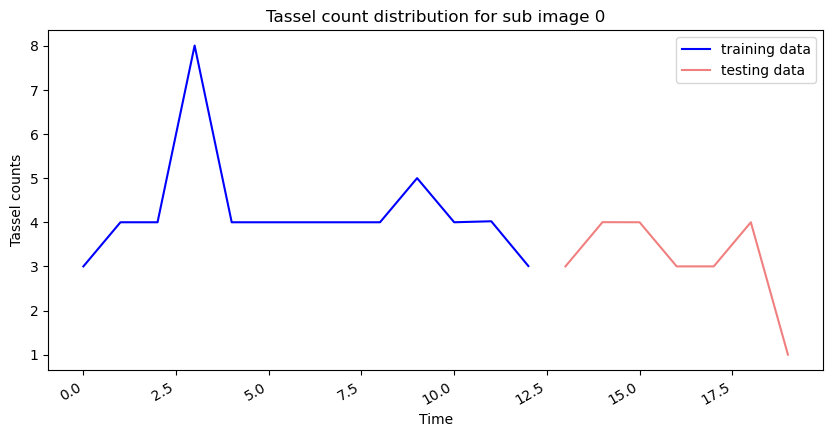

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_tassel_count_data(Train_Y_sub_0, Test_Y_sub_0, 0, (fig, ax))

In [30]:
run_mcmc_sub_0 = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)

In [31]:
%%time
gam_with_latent_ar_sub_0 = generate_model_ar_latent(X_preds_only_sub_0, n_predictors_sub_0, training=True)

CPU times: user 226 µs, sys: 123 µs, total: 349 µs
Wall time: 356 µs


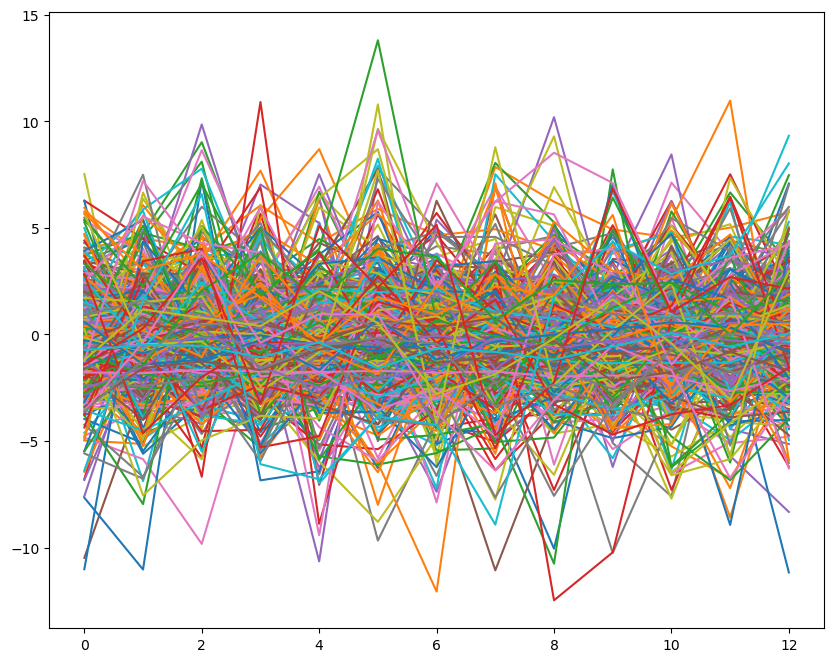

In [32]:
plt.figure(figsize = (10,8))
plt.plot(tf.transpose(gam_with_latent_ar_sub_0.sample(500)[-1]))
plt.show()

In [33]:
%%time
# The mcmc with nuts sample happens below
mcmc_samples_sub_0, sampler_stats_sub_0 = run_mcmc_sub_0(
    2000, gam_with_latent_ar_sub_0, n_chains=4, num_adaptation_steps=1000,
    seed=tf.constant([36245, 734565], dtype=tf.int32),
    observed=Train_Y_sub_0.T)

2024-07-01 09:35:36.989692: I external/local_xla/xla/service/service.cc:168] XLA service 0x55f705a243f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-01 09:35:36.989764: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-01 09:35:37.595686: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure/ldj_reduction_ndims/assert_equal_1/Assert/Assert
2024-07-01 09:35:37.628260: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure_of_jointmap_of_reshape_and_reshape_1_and_reshape_2_and_reshape_3_and_reshape_4/ldj_reduction_ndims_5/assert_equal_1/Assert/Assert
2024-07-01 09:35:37.716007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-

CPU times: user 36.8 s, sys: 1.26 s, total: 38 s
Wall time: 38.6 s


In [34]:
gam_with_latent_ar_full_sub_0 = generate_model_ar_latent(X_preds_only_sub_0, n_predictors_sub_0, training=False)
posterior_dists_sub_0, ppc_samples_sub_0 = gam_with_latent_ar_full_sub_0.sample_distributions(value=mcmc_samples_sub_0)

In [35]:
nchains = 4

In [36]:
len(mcmc_samples_sub_0)

5

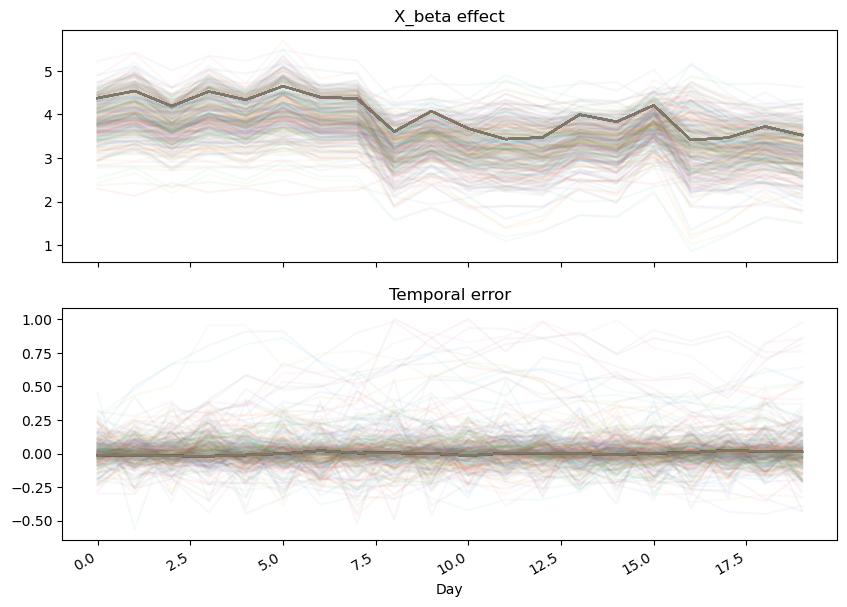

In [37]:
# plot the posteriors ? for betas and temporal errors
preds_and_temoral_error(mcmc_samples_sub_0, X_preds_only_sub_0, n_total_time_points = 20)

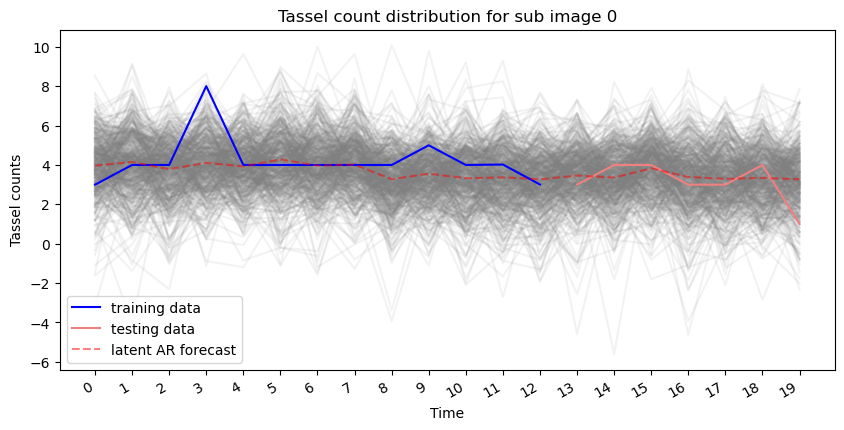

In [38]:
# Plot the forecated and actual values
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig_ax = (fig, ax)
forecasted_and_actual_values_plot(ppc_samples_sub_0, Train_Y_sub_0, Test_Y_sub_0, 0, fig_ax)

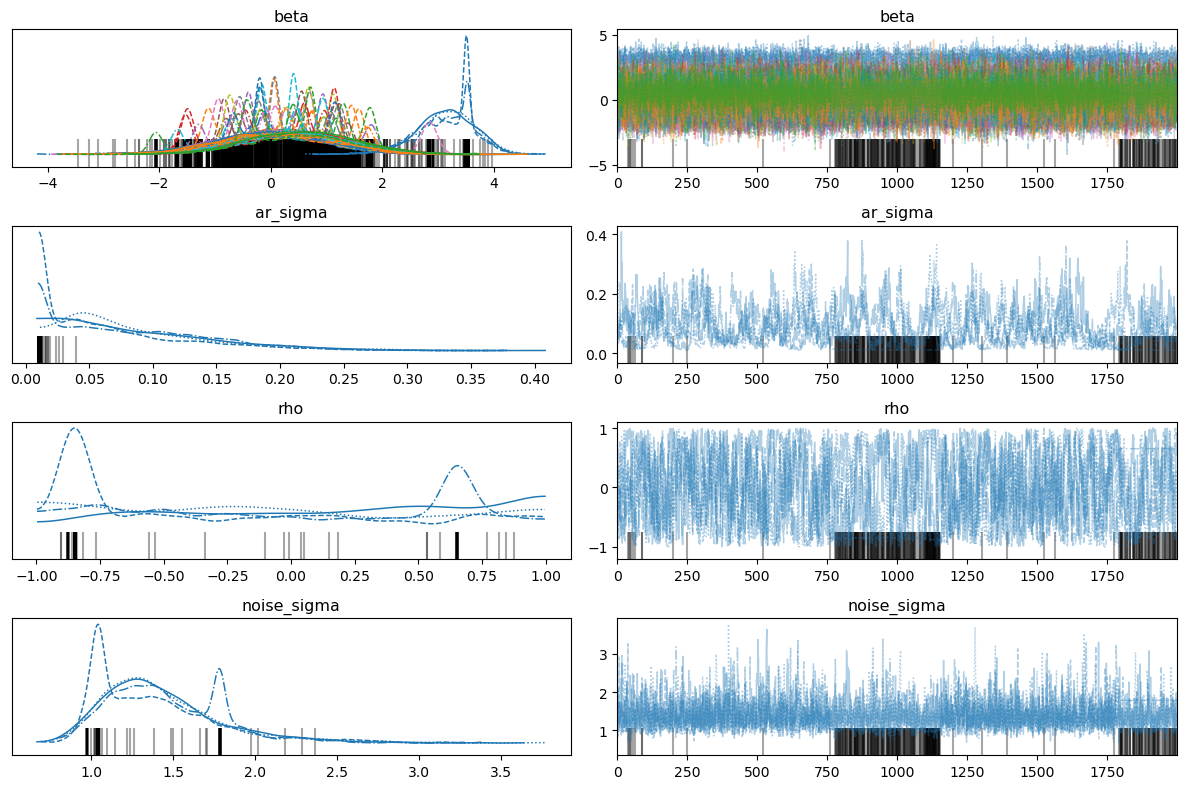

In [39]:
# Get the posterior plots
nuts_output_sub_0 = get_nuts_values_and_posterior_plots(mcmc_samples_sub_0, sampler_stats_sub_0)

In [40]:
rho_values_sub_0, ar_sigma_values_sub_0, noise_sigma_values_sub_0, beta_vals_all_sub_0 = posterior_vals(nuts_output_sub_0)

(4, 2000)
(4, 2000)
(4, 2000)
(4, 2000, 33)


In [41]:
# get the betas gathered and plot them all in a single plot
all_betas_sub_0 = []
for i in range(33):
    betas = beta_vals_all_sub_0[: ,: , i]
    all_betas_sub_0.append(betas)
len(all_betas_sub_0)

33

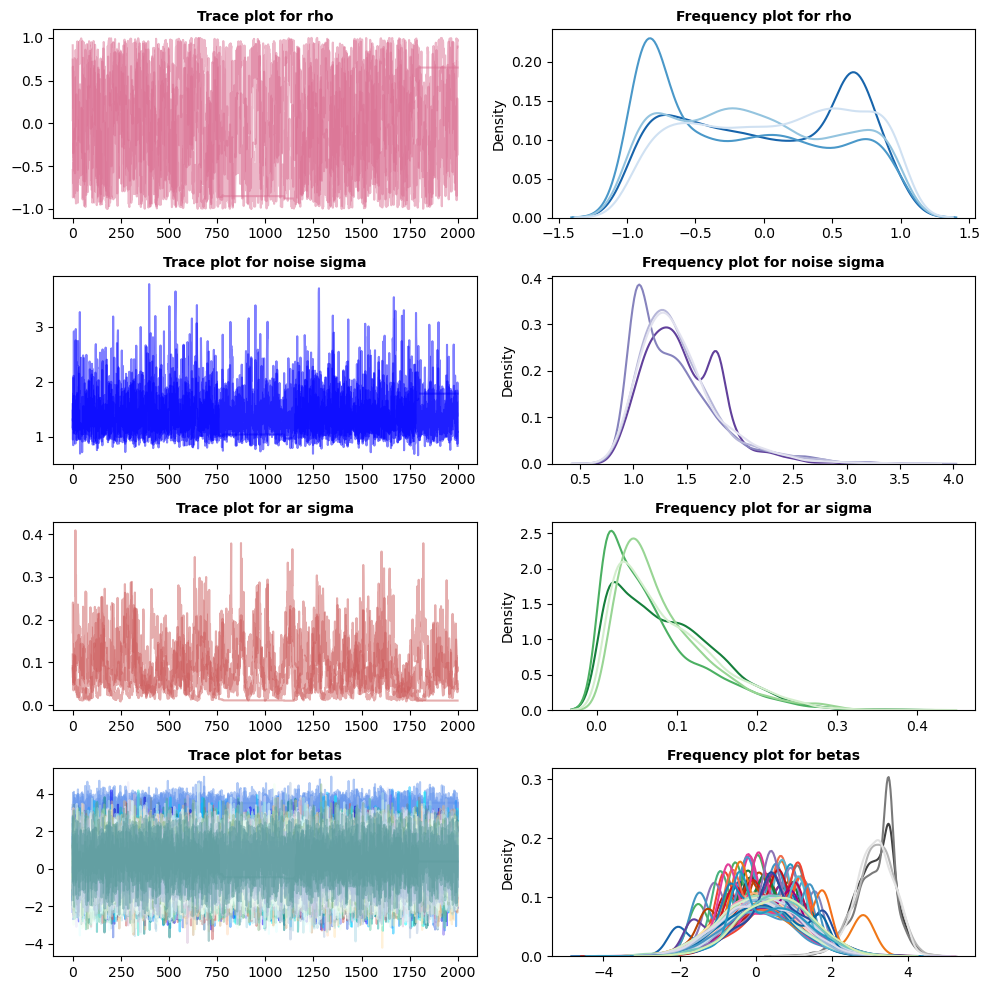

In [42]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
get_trace_plots(axs[0, 0], rho_values_sub_0, 'palevioletred', 'rho')
get_trace_plots(axs[1, 0], noise_sigma_values_sub_0, 'blue', 'noise sigma')
get_trace_plots(axs[2, 0], ar_sigma_values_sub_0, 'indianred', 'ar sigma')
for i in range(33):
    get_trace_plots(axs[3, 0], all_betas_sub_0[i], color_list[i], 'betas')
fig.tight_layout()
get_freq_curves(axs[0, 1], rho_values_sub_0, 'Blues', 'rho')
get_freq_curves(axs[1, 1], noise_sigma_values_sub_0, 'Purples', 'noise sigma')
get_freq_curves(axs[2, 1], ar_sigma_values_sub_0, 'Greens', 'ar sigma')
for i in range(33):
    get_freq_curves(axs[3, 1], all_betas_sub_0[i], color_palletes_betas[i], 'betas')
fig.tight_layout()
    # plt.plot(all_betas[i].T, color = color_list[i], alpha = 0.5)
plt.savefig('figures/all_trace_plots_sub_0.png')
plt.show()

In [43]:
# Okay, these are all the steps, we just need to figure out how to save the forecasted values - where are these values? Note that this exercise needs to be repeated for each sub images, and thereby to each block. We need to think if there is a better way to do this.

In [44]:
# get the forecasted values
forecasted_values_sub_0 = ppc_samples_sub_0[-1].numpy()
averaged_forecast_sub_0 = np.mean(forecasted_values_sub_0, axis=(0, 1)).T

In [45]:
forecasted_values_sub_0.shape, averaged_forecast_sub_0.shape

((2000, 4, 20), (20,))

In [46]:
# we may need to store the averaged forecasts - extract these first
test_averaged_forecast_sub_0 = averaged_forecast_sub_0[-7:]
test_all_forecasts_sub_0 = forecasted_values_sub_0[:,:,-7:]

In [47]:
# save these for future?
# may be save the bulk forecasts (chains and steps) as a np array, and the averaged counts with the true values in a dataframe?

In [48]:
forecasted_values_sub_0 = pd.DataFrame(zip(Test_Y_sub_0, test_averaged_forecast_sub_0), columns = ['True_value', 'Forecasted_value'])

In [49]:
# save these

# save the dataframe
forecasted_values_sub_0.to_csv("forecasted_counts/block_0103/averaged_forecasts_sub_0.csv", index = False)

# save the np array
np.save("forecasted_counts/block_0103/all_forecasts_sub_0.npy", test_all_forecasts_sub_0)

In [50]:
# load and see if these are the same
loaded_forecasts = np.load("forecasted_counts/block_0103/all_forecasts_sub_0.npy")
np.mean(loaded_forecasts == test_all_forecasts_sub_0)

1.0